### Learning Objectives

Upon completion of this notebook, you will be able to:

* **Apply sensor abstraction techniques** by binning high-dimensional LiDAR point clouds into simplified spatial cones (Front, Left, Right) to minimize noise and computational overhead.
* **Construct a robust data pipeline** that employs normalization and episode-based splitting to prevent data leakage and ensure model generalization across varying physical terrains.
* **Design a lightweight Multilayer Perceptron (MLP)** architecture optimized for embedded deployment, incorporating Dropout regularization to maintain stability against intermittent sensor failure.
* **Implement Supervised Imitation Learning** using Mean Squared Error (MSE) to map raw environmental perception directly to continuous motor control commands (Steer/Forward).
* **Quantitatively and qualitatively validate robotic behavior** by correlating sensor inputs with predicted actions through RMSE analysis and behavior visualization.

---

### What is End-to-End Imitation Learning?

End-to-End Imitation Learning, or Behavioral Cloning, is a paradigm where a robot learns to perform a task by mimicking an "expert" agent. Instead of manually writing complex `if-then` rules for every possible obstacle configuration, the robot observes sensor data and corresponding motor actions, learning a direct mapping from **Perception** to **Action**.

This workshop focuses on bridging the "Sim-to-Real" gap using the Kaggle IRND dataset, which offers:

* **Real-World Noise Handling:** Training on physical sensor data from a wheeled robot rather than perfect, noiseless simulations.
* **Terrain Adaptability:** Learning control policies that remain consistent whether the robot is navigating on smooth floors or high-friction rough surfaces.
* **Efficient Control Mapping:** Reducing 360° LiDAR sweeps into a three-channel input that can be processed in milliseconds on low-power hardware.
* **Interpretable Robotics:** Using visualization to verify that the "reason" (a detected obstacle) leads to the correct "result" (a steering maneuver).


In [ ]:
import os
import json
import glob
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

import kaggle

# Define the dataset identifier
dataset = "narayananpp/indoor-robot-navigation-dataset-irnd"

# Download and unzip
kaggle.api.dataset_download_files(dataset, path='./robot_data', unzip=True)

print("Dataset downloaded and extracted to ./robot_data")

Dataset URL: https://www.kaggle.com/datasets/narayananpp/indoor-robot-navigation-dataset-irnd
Dataset downloaded and extracted to ./robot_data


## 1. Data Preparation & Engineering

The raw data consists of 276 JSON episodes recorded from a wheeled robot navigating smooth and rough surfaces.

* **Sensor Binning:** Real LiDAR provides 360+ points of depth data. We "bin" these into three virtual sensors—**Front, Left, and Right**—by taking the minimum distance within specific angular cones. This reduces high-dimensional noise while preserving critical obstacle information.
* **Normalization:** We normalize LiDAR distances (clipping at 5m) and wheel encoder counts (scaling 0–2000 to a range of -1 to 1). This ensures the neural network receives inputs and targets on a similar scale, preventing gradient explosion.
* **Data Splitting:** To ensure the model generalizes to new environments, we split the data by **episodes** (files) rather than individual time steps. This prevents "data leakage" where the model might simply memorize a specific room layout.


In [ ]:
class RobotLidarDataset(Dataset):
    def __init__(self, file_paths):
        self.inputs = []
        self.targets = []

        for file in file_paths:
            with open(file, 'r') as f:
                content = json.load(f)
                for step in content['data']:
                    # Extract LiDAR
                    angles = np.array(step['angles']) # -180 to 180
                    dists = np.array(step['dists'])

                    # Create 3-sector "virtual" sensors
                    # Front: -20 to 20 deg, Left: 70 to 110 deg, Right: -110 to -70 deg
                    f_mask = (angles > -20) & (angles < 20)
                    l_mask = (angles > 70) & (angles < 110)
                    r_mask = (angles > -110) & (angles < -70)

                    # Clean data: Replace 0.0 or Inf with a max range (5.0 meters)
                    def get_min_dist(mask):
                        vals = dists[mask]
                        vals = vals[vals > 0.1] # ignore noise very close to sensor
                        return np.min(vals) if len(vals) > 0 else 5.0

                    front = get_min_dist(f_mask)
                    left = get_min_dist(l_mask)
                    right = get_min_dist(r_mask)

                    # Normalize wheel counts (max 2000) to controls
                    # steer: [-1, 1], forward: [0, 1]
                    c_l = step['counts_left'] / 2000.0
                    c_r = step['counts_right'] / 2000.0

                    forward = (c_l + c_r) / 2.0
                    steer = c_r - c_l

                    self.inputs.append([front, left, right])
                    self.targets.append([steer, forward])

        self.inputs = np.array(self.inputs, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [ ]:
def visualize_sample_data(dataset):
    sample_idx = np.random.randint(len(dataset))
    inp, tar = dataset[sample_idx]

    labels = ['Front', 'Left', 'Right']
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.bar(labels, inp, color=['red', 'blue', 'green'])
    plt.title(f"Sensor Inputs (m)\nSample {sample_idx}")
    plt.ylim(0, 6)

    plt.subplot(1, 2, 2)
    plt.bar(['Steer', 'Forward'], tar, color='orange')
    plt.title("Expert Actions")
    plt.ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

## 2. Model Architecture

We use a **Multilayer Perceptron (MLP)** designed for real-time inference.

* **Input Layer:** 3 neurons (representing the Front, Left, and Right depth sensors).
* **Hidden Layers:** Two dense layers (64 and 32 neurons) with **ReLU (Rectified Linear Unit)** activation functions. This architecture is deep enough to learn non-linear avoidance maneuvers but light enough to run on embedded robot hardware (like a Raspberry Pi or Jetson Nano).
* **Regularization:** We include a **Dropout layer (20%)** during training. This forces the network to remain robust even if one sensor (e.g., the "Left" sensor) provides noisy or "ghost" readings.
* **Output Layer:** 2 neurons representing the **Control Commands**:
1. **Steer:** A value between -1 (Hard Right) and 1 (Hard Left).
2. **Forward:** A value between 0 (Stop) and 1 (Full Speed).

In [ ]:
class AvoidancePolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout helps with real-world sensor noise
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)


## 3. Model Training

The training process uses **Supervised Imitation Learning**.

* **Loss Function:** We utilize **Mean Squared Error (MSE)**. The goal is to minimize the difference between the network's predicted action and the "expert" wheel counts recorded in the dataset.
* **Optimizer:** The **Adam Optimizer** is used for its adaptive learning rate, which is particularly effective when dealing with the non-stationary noise found in real-world robotics data.
* **Training Loop:** The model iterates through the dataset for 20+ epochs, adjusting internal weights to better replicate the expert's driving style on both smooth and rough terrain.


## 4. Evaluation and Visualization

Since this is a robotics project, we evaluate the model using both statistical and spatial metrics.

* **Statistical Metrics:** We calculate the **Root Mean Square Error (RMSE)** on the test set. This tells us, on average, how many "counts" off our steering predictions are compared to the human driver.
* **Action Visualizer:** We generate bar charts comparing the sensor input (the "reason") to the predicted action (the "result"). For example, if the *Front* sensor is low (close obstacle), we verify that the *Forward* command drops and the *Steer* command moves away from 0.
* **Learning Curve:** We plot the training loss vs. validation RMSE to ensure the model is converging and not overfitting to a specific surface type.

Loading 220 training episodes...


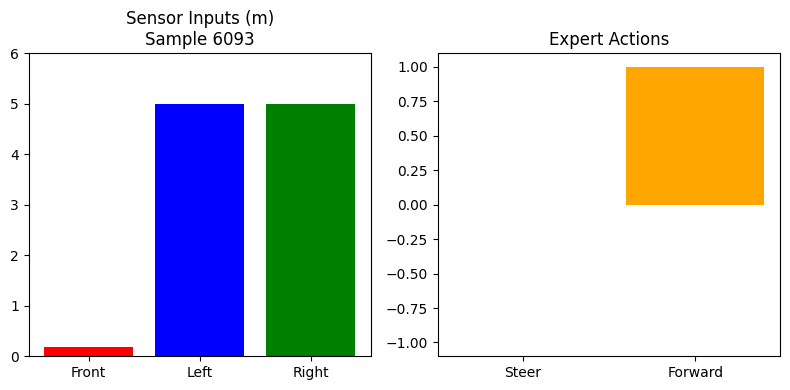

Starting Training...
Epoch 00 | Loss: 0.1406 | RMSE: 0.3667
Epoch 05 | Loss: 0.1320 | RMSE: 0.3694
Epoch 10 | Loss: 0.1314 | RMSE: 0.3646
Epoch 15 | Loss: 0.1316 | RMSE: 0.3656
Epoch 19 | Loss: 0.1312 | RMSE: 0.3634


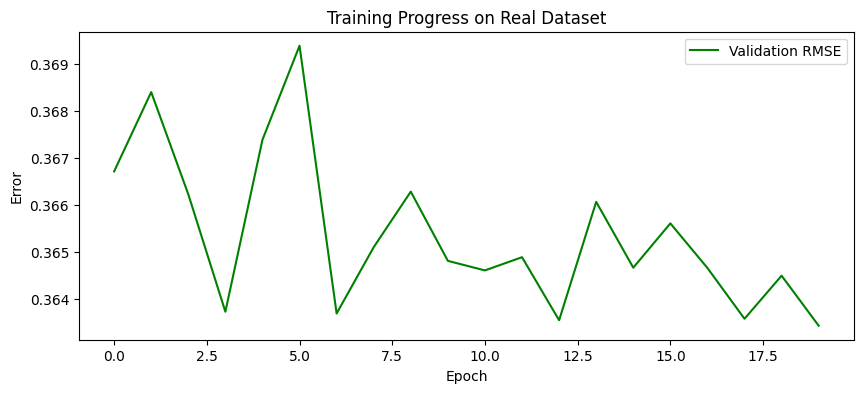

In [ ]:
data_files = glob.glob("/content/robot_data/outputs/*.json") + glob.glob("/content/robot_data/outputs_2/*.json")

if not data_files:
    print("No files found. Please check your directory paths.")
else:
    train_files, test_files = train_test_split(data_files, test_size=0.2, random_state=42)

    print(f"Loading {len(train_files)} training episodes...")
    train_dataset = RobotLidarDataset(train_files)
    test_dataset = RobotLidarDataset(test_files)

    visualize_sample_data(train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AvoidancePolicy().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epochs = 20
    history = {'train_loss': [], 'test_rmse': []}

    print("Starting Training...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        test_err = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                test_err += torch.sum((pred - y)**2).item()

        rmse = (test_err / (len(test_dataset) * 2))**0.5
        history['train_loss'].append(total_loss / len(train_loader))
        history['test_rmse'].append(rmse)

        if epoch % 5 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch:02d} | Loss: {history['train_loss'][-1]:.4f} | RMSE: {rmse:.4f}")
    plt.figure(figsize=(10, 4))
    plt.plot(history['test_rmse'], label='Validation RMSE', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Training Progress on Real Dataset')
    plt.legend()
    plt.show()

## 5. Summary

This project demonstrates an **End-to-End Learning** approach where raw sensor data is mapped directly to motor commands. Using Kaggle IRND dataset, we account for real-world complexities like surface friction, sensor noise, and mechanical constraints.